# Check sync process

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datajoint as dj

import u19_pipeline.ephys_pipeline as ephys_pipeline
import u19_pipeline.utils.ephys_utils as ephys_utils
import u19_pipeline.utils.ephys_fix_sync_code as ephys_fix_sync_code


[2025-12-17 13:59:00,478][INFO]: DataJoint 0.14.4 connected to alvaros@datajoint00.pni.princeton.edu:3306


In [3]:
recording_query = "recording_id > 500 and recording_id < 512"
recording = dj.create_virtual_module('recording', 'u19_recording')
recording_keys = (recording.Recording & recording_query).fetch('recording_id', as_dict=True, order_by='recording_id')


session_fields = ['subject_fullname', 'session_date', 'session_number']
session_keys = (recording.Recording.BehaviorSession & recording_query).fetch(*session_fields, as_dict=True, order_by='recording_id')


recording_keys

[{'recording_id': np.int64(501)},
 {'recording_id': np.int64(502)},
 {'recording_id': np.int64(503)},
 {'recording_id': np.int64(504)},
 {'recording_id': np.int64(505)},
 {'recording_id': np.int64(506)},
 {'recording_id': np.int64(507)},
 {'recording_id': np.int64(508)},
 {'recording_id': np.int64(509)},
 {'recording_id': np.int64(510)},
 {'recording_id': np.int64(511)}]

In [4]:
def main_ephys_fix_sync_code(iter_start_idx, iter_times_idx, behavior_time, nidq_sampling_rate, key):
    iteration_dict = dict()
    iteration_dict['iter_start_idx']  = list()
    iteration_dict['iter_times_idx']  = list()
    iteration_dict['trial_sync_stats'] = list()

    for i in range(len(iter_start_idx)):

        trial_stats_dict= {}
        trial_stats_dict['num_trial'] = i+1

        #print('fixing trial ',i)
        behavior_time_vector = behavior_time[i].flatten()

        synced_time_vector, shift_vec, median_vec = ephys_fix_sync_code.get_shift_vector(iter_times_idx[i],behavior_time_vector)
        trial_stats_dict['max_shift'] = np.max(shift_vec)
        trial_stats_dict['min_shift'] = np.min(shift_vec)
        trial_stats_dict['median_diff'] = median_vec[1]
        trial_stats_dict['min_diff'] = median_vec[0]
        trial_stats_dict['max_diff'] = median_vec[2]

        synced_time_vector,trial_stats_dict['borrow_step2'] =\
            ephys_fix_sync_code.fix_shifted_sync_vector(synced_time_vector, behavior_time_vector, shift_vec)

        #synced_time_vector, trial_stats_dict['borrow_step3'] =\
        #    fix_sync_vector_greater(synced_time_vector, behavior_time_vector)
        synced_time_vector,trial_stats_dict['borrow_step4'] =\
            ephys_fix_sync_code.complete_last_part_sync_vec(synced_time_vector, behavior_time_vector)

        synced_iteration_vector =\
            ephys_fix_sync_code.fix_iter_vector(iter_start_idx[i],synced_time_vector, iter_times_idx[i], nidq_sampling_rate)
        
        trial_stats_dict['num_iterations'] = synced_iteration_vector.shape[0] 
        
        trial_stats_dict = trial_stats_dict | key
        iteration_dict['trial_sync_stats'].append(trial_stats_dict)


        iteration_dict['iter_start_idx'].append(synced_iteration_vector.copy())
        iteration_dict['iter_times_idx'].append(synced_time_vector.copy())

    print('end fix sync code 1')

    iteration_dict['iter_start_idx'] = np.asarray(iteration_dict['iter_start_idx'].copy(), dtype=object)
    iteration_dict['iter_times_idx'] = np.asarray(iteration_dict['iter_times_idx'].copy(), dtype=object)

    print('end fix sync code')

    # Check # of trials and iterations match
    trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

    print('after assert_iteration_samples_count fix sync code')

    if trial_count_diff != 0:
        print('trial_count_diff', trial_count_diff)
    if len(trials_diff_iteration_big) > 0:
        print('trials_diff_iteration_big', trials_diff_iteration_big)
    if len(trials_diff_iteration_small) > 0:
        print('trials_diff_iteration_small', trials_diff_iteration_small)


    status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small,  behavior_time.shape[0])

    print('after evaluate_sync_process fix sync code')

    for i in range(len(iteration_dict['iter_start_idx'])):
        synced_time_vector = iteration_dict['iter_times_idx'][i]
        behavior_time_vector = behavior_time[i].flatten()

        status = ephys_fix_sync_code.sync_evaluation_process2(synced_time_vector, behavior_time_vector)
        if status == -1:
            break

    print('after sync_evaluation_process2', status)

    if status == 1:
        iteration_dict['trial_start_idx'] = ephys_utils.get_index_trial_vector_from_iteration(iteration_dict['iter_start_idx'])


    return status, iteration_dict

In [5]:
def main_regular_sync(key, **kwargs):

    ephys_session_fullpath = ephys_pipeline.get_full_session_directory(key)

    # Get behavior key
    behavior_key = (recording.Recording.BehaviorSession & key).fetch1()
    behavior_key.pop('recording_id')

    if 'testuser' in behavior_key['subject_fullname']:
        return

    # If a specific block is requested, add that to our behavior_key. It should be an int referring to virmen block number.
    # This is useful for sessions in which the nidaq stream was interrupted due to restarting virmen
    if 'block' in kwargs:
        print('block: ', kwargs['block'])
        behavior_key['block'] = kwargs['block']

    print(behavior_key)

    # And get the datajoint record
    behavior = dj.create_virtual_module('behavior', 'u19_behavior')
    thissession = behavior.TowersBlock().Trial() & behavior_key
    behavior_time, iterstart = thissession.fetch('trial_time', 'vi_start')

    print('len iterstart', len(iterstart))

    if len(iterstart) == 0:
        raise ValueError('No behavior found')

    print('after reading behavior data')

    # 1: load meta data, and the content of the NIDAQ file. Its content is digital.
    nidq_meta, nidq_sampling_rate = ephys_utils.read_nidq_meta_samp_rate(ephys_session_fullpath)

    trial_pulse_signal, iteration_pulse_signal = ephys_utils.load_trial_iteration_signals(ephys_session_fullpath, nidq_meta)

    print('after reading spikeglx data')

    # Synchronize between pulses and get iteration # vector for each sample
    recent_recording = behavior_key['session_date'] > datetime.date(2021,6,1) # Everything past June 1 2021
    if recent_recording:
        # New synchronization method: digital_array[1,2] contain pulses for trial and frame number.
        mode=None
        iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_pulses(trial_pulse_signal, iteration_pulse_signal, nidq_sampling_rate, behavior_time.shape[0], behavior_time, mode)
    else:
        # Old synchronization: digital_array[0:7] contain a digital word that counts the virmen frames.
        raise ValueError('Old sessions < 2022 not suported anymore')
        #iteration_dict = ephys_utils.get_iteration_sample_vector_from_digital_lines_word(digital_array, behavior_time, iterstart)

    # Check # of trials (from database record of behavior in `behavior_time`) and iterations (extracted from NIDAQ in `iter_start_idx`) match
    trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small = ephys_utils.assert_iteration_samples_count(iteration_dict['iter_start_idx'], behavior_time)

    print('metrics to evaluate...')
    print(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small, behavior_time.shape[0])

    status = ephys_utils.evaluate_sync_process(trial_count_diff, trials_diff_iteration_big, trials_diff_iteration_small, behavior_time.shape[0])

    if status == 1:
        iteration_dict['trial_start_idx'] = ephys_utils.get_index_trial_vector_from_iteration(iteration_dict['iter_start_idx'])

    #Failed sync by a lot, error
    status_regular = 1
    status_fix = 0
    if status < 1:
        status_regular = 0
        print('Regular ephys sync failed')
    
    try:
        status_fix, iteration_dict2 = main_ephys_fix_sync_code(iteration_dict['iter_start_idx'], iteration_dict['iter_times_idx'], behavior_time, nidq_sampling_rate, key)
    except:
        status_fix = 0
        iteration_dict2 = {}

    return status_fix, iteration_dict2

In [6]:

num_session = 0
for idx_session in range(len(recording_keys)):

    recording_key = recording_keys[idx_session]
    session_key = session_keys[idx_session]

    status_fix, iteration_dict2 = main_regular_sync(recording_key)
    if status_fix == 0:
        continue

    print('status_fix', status_fix)
    print('num_session', num_session)
    
    if num_session == 0:
        trial_sync_stats_df = pd.DataFrame(iteration_dict2['trial_sync_stats'])
    else:
        trial_sync_stats_df = pd.concat([trial_sync_stats_df, pd.DataFrame(iteration_dict2['trial_sync_stats'])], axis=0)

    num_session += 1

    


/mnt/cup/braininit/Data/Raw/electrophysiology/jyanar/jyanar_ya054/20251012_g0/ya054_20251012_g0
{'subject_fullname': 'jyanar_ya054', 'session_date': datetime.date(2025, 10, 12), 'session_number': 0}
len iterstart 266
after reading behavior data
nChan: 4, nFileSamp: 113704412
after reading spikeglx data
len trial_start_idx (266,)
mode deduction:  pulse_signal
trial# 0 iterPulses: 1114 IterBeh: 1116
trial# 6 iterPulses: 476 IterBeh: 477
trial# 11 iterPulses: 711 IterBeh: 712
trial# 25 iterPulses: 635 IterBeh: 636
trial# 35 iterPulses: 533 IterBeh: 534
trial# 49 iterPulses: 597 IterBeh: 598
trial# 55 iterPulses: 590 IterBeh: 591
trial# 57 iterPulses: 513 IterBeh: 514
trial# 65 iterPulses: 595 IterBeh: 596
trial# 78 iterPulses: 1027 IterBeh: 1028
trial# 86 iterPulses: 573 IterBeh: 574
trial# 96 iterPulses: 563 IterBeh: 564
trial# 98 iterPulses: 544 IterBeh: 545
trial# 115 iterPulses: 1082 IterBeh: 1083
trial# 118 iterPulses: 517 IterBeh: 518
trial# 124 iterPulses: 1092 IterBeh: 1093
trial#

In [7]:
def count_borrowed_iter(borrow_list):
    num_borrow = 0
    for i in range(len(borrow_list)):
        num_borrow = num_borrow+ borrow_list[i][1] - borrow_list[i][0] + 1

    return num_borrow


In [8]:

trial_sync_stats_df['min_shift_abs'] = trial_sync_stats_df['min_shift'].abs()
trial_sync_stats_df['shift'] = trial_sync_stats_df[['max_shift', 'min_shift_abs']].max(axis=1)

trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift'] = trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift']*-1

trial_sync_stats_df['num_borrow_step2'] = trial_sync_stats_df['borrow_step2'].apply(count_borrowed_iter)
#trial_sync_stats_df['num_borrow_step3'] = trial_sync_stats_df['borrow_step3'].apply(count_borrowed_iter)
trial_sync_stats_df['num_borrow_step4'] = trial_sync_stats_df['borrow_step4'].apply(count_borrowed_iter)


#trial_sync_stats_df['total_borrow'] = trial_sync_stats_df['num_borrow_step2'] + trial_sync_stats_df['num_borrow_step3'] + trial_sync_stats_df['num_borrow_step4']  

trial_sync_stats_df['total_borrow'] = trial_sync_stats_df['num_borrow_step4'] + trial_sync_stats_df['num_borrow_step2']

trial_sync_stats_df['percentage_borrow'] = trial_sync_stats_df['total_borrow']*100 / trial_sync_stats_df['num_iterations']


trial_sync_stats_df

,num_trial,max_shift,min_shift,median_diff,min_diff,max_diff,borrow_step2,borrow_step4,num_iterations,recording_id,min_shift_abs,shift,num_borrow_step2,num_borrow_step4,total_borrow,percentage_borrow
0,1,0,-1,-0.093753,-0.100753,-0.086753,"[[1015, 1021]]","[[1113, 1115]]",1116,501,1,-1,7,3,10,0.896057
1,2,0,0,-0.031356,-0.038356,-0.024356,[],[],585,501,0,0,0,0,0,0.000000
2,3,0,0,-0.041089,-0.048089,-0.034089,[],[],470,501,0,0,0,0,0,0.000000
3,4,0,0,-0.023886,-0.030886,-0.016886,[],[],546,501,0,0,0,0,0,0.000000
4,5,0,0,-0.074538,-0.081538,-0.067538,[],[],487,501,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,311,0,0,-0.010003,-0.017003,-0.003003,[],[],1819,511,0,0,0,0,0,0.000000
311,312,0,0,-0.010694,-0.017694,-0.003694,[],[],2198,511,0,0,0,0,0,0.000000
312,313,0,0,-0.010398,-0.017398,-0.003398,[],[],1881,511,0,0,0,0,0,0.000000
313,314,0,0,-0.009699,-0.016699,-0.002699,[],[],1041,511,0,0,0,0,0,0.000000


In [17]:
trial_sync_stats_df['min_shift_abs'].max()

np.int64(1)

Text(0.5, 1.0, 'Median diff NIDAQ - ViRMEn')

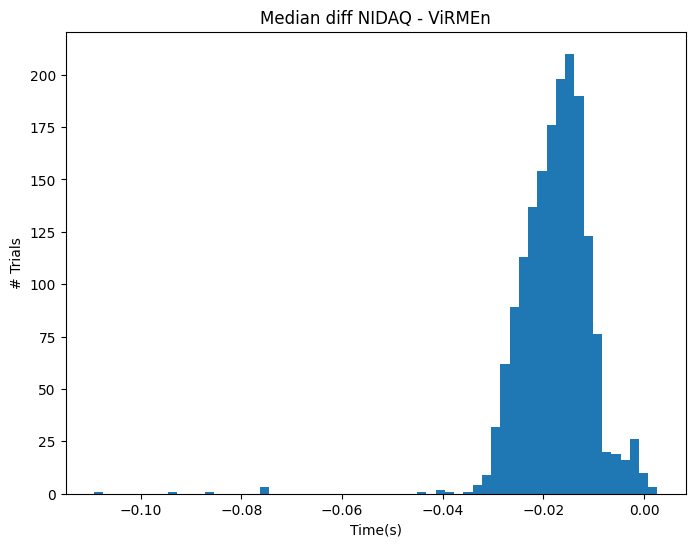

In [18]:
plt.figure(figsize=(8, 6))

shift_stats = trial_sync_stats_df['median_diff'].copy()
num_0_shifts = (shift_stats == 0).sum()

num_shifts = shift_stats[shift_stats != 0]


plt.hist(num_shifts,bins=61)


plt.xlabel('Time(s)')
plt.ylabel('# Trials')
plt.title('Median diff NIDAQ - ViRMEn')

In [19]:

trial_sync_stats_df['min_shift_abs'] = trial_sync_stats_df['min_shift'].abs()
trial_sync_stats_df['shift'] = trial_sync_stats_df[['max_shift', 'min_shift_abs']].max(axis=1)

trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift'] = trial_sync_stats_df.loc[trial_sync_stats_df['shift']==trial_sync_stats_df['min_shift_abs'], 'shift']*-1


Text(0.5, 1.0, '"Max" shift in trial to preserve median: 1611 trials without shift')

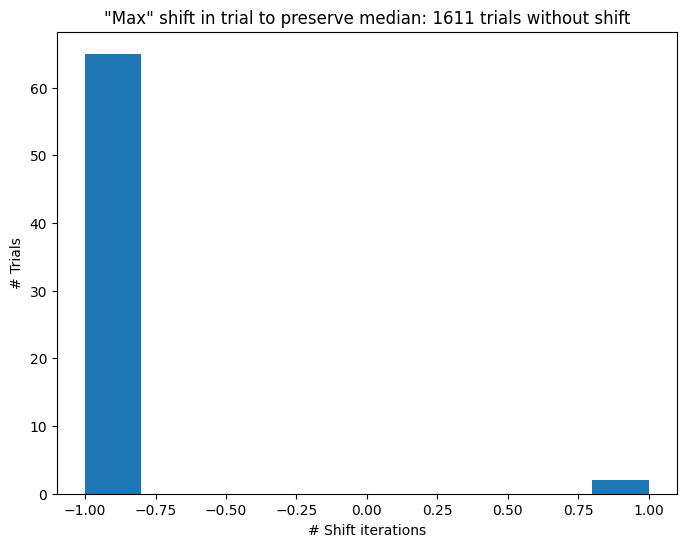

In [20]:
plt.figure(figsize=(8, 6))

shift_stats = trial_sync_stats_df['shift'].copy()
num_0_shifts = (shift_stats == 0).sum()

num_shifts = shift_stats[shift_stats != 0]


plt.hist(num_shifts)


plt.xlabel('# Shift iterations')
plt.ylabel('# Trials')
plt.title('"Max" shift in trial to preserve median: '+ str(num_0_shifts)+ ' trials without shift')

Text(0.5, 1.0, 'Trial NIDAQ iterations borrowed from ViRMEn')

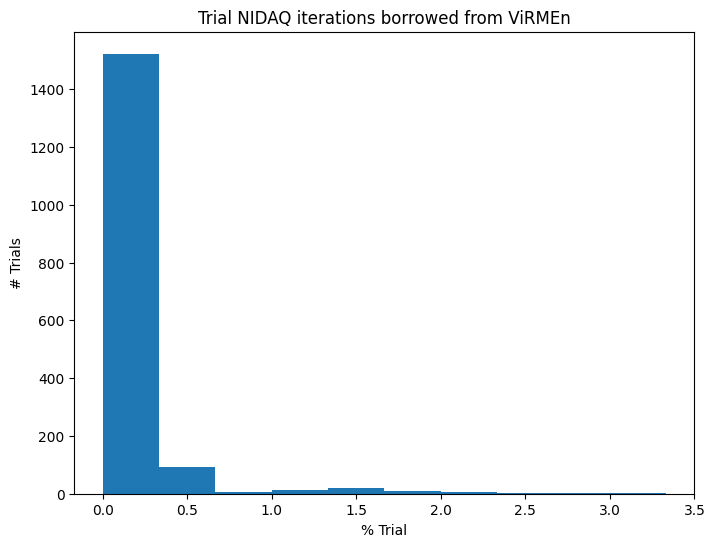

In [21]:
plt.figure(figsize=(8, 6))



plt.hist(trial_sync_stats_df['percentage_borrow'])


plt.xlabel('% Trial')
plt.ylabel('# Trials')
plt.title('Trial NIDAQ iterations borrowed from ViRMEn')